# Linear operators

This notebook will be used to introduce the core concepts of *Linear Operators* and how they can be developed and used to solve inverse problems.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops
import scooby

from scipy.linalg import lstsq
from pylops import LinearOperator
from pylops.utils import dottest

We will consider the following operators:
    
- Diagonal
- First Derivative
- 2D convolution

## Diagonal

Let's start by creating a barebore linear operator that performs a simple element-wise multiplication:

$$ y_i = d_i x_i  \quad \forall i=1,2,...,N $$

We will call this operator $\mathbf{D}$ and show how we can either use a diagonal matrix or a linear operator to perform the very same operations:

- Forward: $\mathbf{D} \mathbf{m}$
- Adjoint: $\mathbf{D}^H \mathbf{d}$

### Linear operator definition

First we define our linear operator

In [2]:
class Diagonal(LinearOperator):
    def __init__(self, diag, dtype='float64'):
        self.diag = diag.flatten()
        self.shape = (len(self.diag), len(self.diag))
        self.dtype = np.dtype(dtype)

    def _matvec(self, x):
        y = self.diag*x
        return y

    def _rmatvec(self, x):
        y = self.diag*x
        return y

Now we compare using the linear operator with doing the same with an explicit matrix

In [3]:
n = 10
diag = np.arange(n)

D = np.diag(diag)
print('D:\n', D)

Dop = Diagonal(diag)
print('Dop: ', Dop)

D:
 [[0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0]
 [0 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 9]]
Dop:  <10x10 Diagonal with dtype=float64>


### Linear operator application

Forward

In [4]:
x = np.ones(n)

# matrix
y = np.dot(D, x)
print('y: ', y)

# lop
y = Dop * x
print('y: ', y)

y:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
y:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


Adjoint

In [5]:
# matrix
xadj = np.dot(D.T, y)
print('xadj: ', xadj)

# lop
xadj = Dop.H * y
print('xadj: ', xadj)

xadj:  [ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]
xadj:  [ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]


### Linear operator testing

In [6]:
dottest(Dop, n, n, verb=True)

Dot test passed, v^T(Opu)=11.278509 - u^T(Op^Tv)=11.278509


True

## First Derivative

Let's consider now something less trivial, where the forward and adjoint are effectively not the same.

We take a first order centered first derivative:

$$ y_i = \frac{x_{i+1} - x_{i-1}}{\Delta}  \quad \forall i=1,2,...,N $$

where $\Delta$ is the sampling step of the input signal. Note that we will deal differently with the edges, using a forward/backward derivative.

### Linear operator definition

In [7]:
nx = 11

D = np.diag(0.5*np.ones(nx-1),k=1) - np.diag(0.5*np.ones(nx-1),-1) 
D[0, 0] = D[-1, -2] = -1
D[0, 1] = D[-1, -1] = 1
print('D:\n', D)

Dop = pylops.FirstDerivative(nx, edge=True)
print('Dop: ', Dop)

dottest(Dop, nx, nx, verb=True);

D:
 [[-1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.5  0.   0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.  -1.   1. ]]
Dop:  <11x11 FirstDerivative with dtype=float64>
Dot test passed, v^T(Opu)=1.219233 - u^T(Op^Tv)=1.219233


### Linear operator application

In [8]:
x = np.arange(nx) - (nx-1)/2
print('x: ', x)

x:  [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


Forward

In [9]:
y = np.dot(D, x)
print('y: ', y)

y = Dop * x
print('y: ', y)

y:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
y:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Inverse

In [10]:
xinv = lstsq(D, y)[0]
print('xinv: ', xinv)

xinv = Dop / y
print('xinv: ', xinv)

xinv:  [-5.00000000e+00 -4.00000000e+00 -3.00000000e+00 -2.00000000e+00
 -1.00000000e+00  6.96836792e-16  1.00000000e+00  2.00000000e+00
  3.00000000e+00  4.00000000e+00  5.00000000e+00]
xinv:  [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


## 2D convolution

Finally we consider a real life example. Imagine we have taken an image of one of the monuments in the city of Timisoara.

However, we forgot our tripod and had a couple of drinks the night before. The image is thus **blurred**. In mathematical terms this is equivalent to applying a 2d convolution filter to the original image. This filter has a certain support in each direction and is filled with 1s. 

While we can easily apply a fast convolution routine like `scipy.signal.convolve` to blur the original image, we want to be able to perform the opposite process, meaning **deblurred**. This is an inverse problem, and this is where linear operators come to rescue. 

We will thus use `pylops.signalprocessing.Convolve2D` to blur our image and two solvers to attempt deblurring it:

- L2 solver
- Blockiness promoting solver

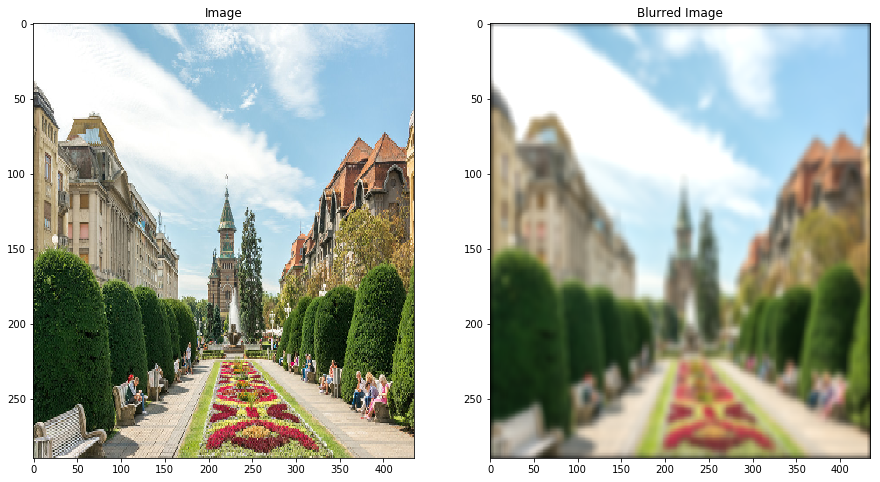

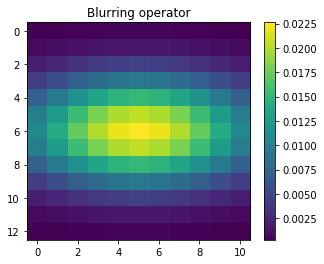

In [28]:
im = np.load('../../data/timisoara.npy')[::2, ::2]
Nz, Nx, Nc = im.shape

# Blurring guassian operator
nh = [13, 11]
hz = np.exp(-0.1*np.linspace(-(nh[0]//2), nh[0]//2, nh[0])**2)
hx = np.exp(-0.03*np.linspace(-(nh[1]//2), nh[1]//2, nh[1])**2)
hz /= np.trapz(hz) # normalize the integral to 1
hx /= np.trapz(hx) # normalize the integral to 1
h = hz[:, np.newaxis] * hx[np.newaxis, :]

# Blur image
Cop = pylops.signalprocessing.Convolve2D(Nz * Nx, h=h,
                                         offset=(nh[0] // 2,
                                                 nh[1] // 2),
                                         dims=(Nz, Nx), dtype='float32')

imblur = np.array([Cop * im[:, :, i].flatten() for i in range(Nc)]) / 255.
imblur[imblur > 1.] = 1.
imblur[imblur < 0.] = 0.

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(im)
axs[0].set_title('Image')
axs[0].axis('tight')
axs[1].imshow(imblur.T.reshape((Nz, Nx, Nc)))
axs[1].set_title('Blurred Image')
axs[1].axis('tight')

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
him = ax.imshow(h)
ax.set_title('Blurring operator')
fig.colorbar(him, ax=ax)
ax.axis('tight');

In [29]:
# Deblur image
imdeblur = np.array([ \
    pylops.optimization.leastsquares.NormalEquationsInversion(Cop, None,
                                                              imblur[i],
                                                              maxiter=50)  
                     for i in range(Nc)])

Dop = [pylops.FirstDerivative(Nz * Nx, dims=(Nz, Nx), dir=0, edge=False),
       pylops.FirstDerivative(Nz * Nx, dims=(Nz, Nx), dir=1, edge=False)]
imdeblurtv = np.array([ \
    pylops.optimization.sparsity.SplitBregman(Cop, Dop, imblur[i],
                                              niter_outer=20, niter_inner=2,
                                              mu=1.5, epsRL1s=[1e-1, 1e-1],
                                              tol=1e-4, tau=1., show=False,
                                              ** dict(iter_lim=5, damp=1e-4))[0]
                       for i in range(Nc)])

# Reshape images
imblur = imblur.T.reshape((Nz, Nx, Nc))
imdeblur = imdeblur.T.reshape((Nz, Nx, Nc))
imdeblurtv = imdeblurtv.T.reshape((Nz, Nx, Nc))

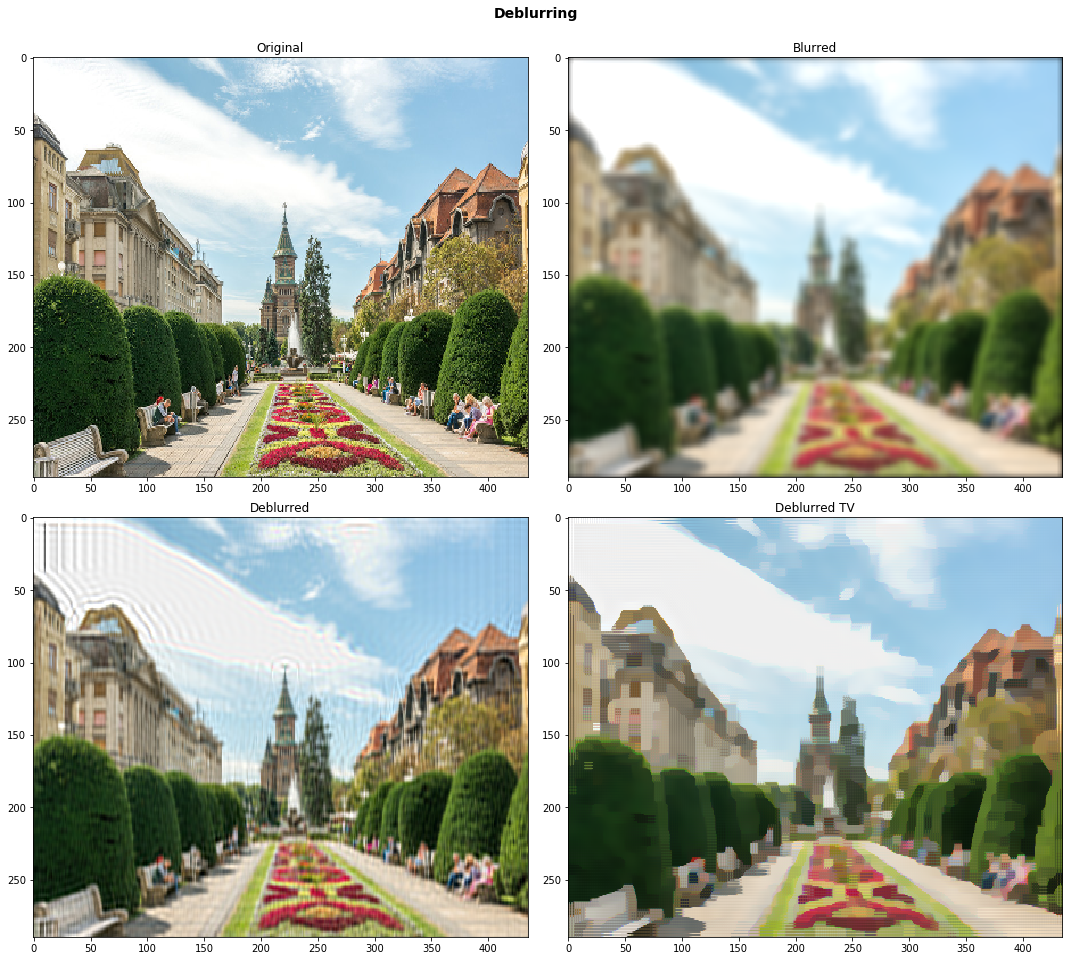

In [30]:
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Deblurring', fontsize=14, fontweight='bold', y=0.95)
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))
ax1.imshow(im, cmap='viridis', vmin=0, vmax=250)
ax1.axis('tight')
ax1.set_title('Original')
ax2.imshow(imblur, cmap='viridis', vmin=0, vmax=250)
ax2.axis('tight')
ax2.set_title('Blurred')
ax3.imshow(imdeblur, cmap='viridis', vmin=0, vmax=250)
ax3.axis('tight')
ax3.set_title('Deblurred')
ax4.imshow(imdeblurtv, cmap='viridis', vmin=0, vmax=250)
ax4.axis('tight')
ax4.set_title('Deblurred TV')
plt.tight_layout()
plt.subplots_adjust(top=0.9)

In [ ]:
scooby.Report(core='pylops')